# Spectral clustering & Epidemic spreading

## Part I - Spectral clustering

For this part of the exercise, you'll repeat the analysis on slides 18 and 19 of the lecture, and compare spectral clustering with the Newman-Girvan edge betweenness clustering algorithm. For the Newman-Girvan algorithm you can use the implementation by `networkx`, but the spectral clustering you have to implement yourself (the $K$-means subroutine you can get from `sklear.cluster.KMeans`).
* Download 5 undirected network datasets with $100 < n < 1000$ (note: if you cannot find sufficient networks of the right size, feel free to download directed or weighted networks and simply transform them to be binary). 
* Implement spectral clustering following the steps in the lecture slides.
* Compute the modularity $Q$ for each clustering for the number of clusters ranging from $k=2, \ldots, n$, and make a plot with $k$ on the horizontal axis and $Q$ on the vertical.
* Add the modularity score obtained by the Newman-Girvan algorithm for the same range of $k$, as on the slides. 
* Which algorithm works best on which dataset? Is there a clear winner?

## Part II - Graphical models & percolation

For this exercise, we'll use data that doesn't originally come in network form. Instead, we have the data for one subject from the [Human Connectome Project](https://www.humanconnectome.org/). We observe, for $n=148$ brain regions, $m=1200$ samples of the fMRI BOLD response. Although this forms a timeseries, we'll treat these observations as independent, and apply the Gaussian graphical model framework to estimate a $n\times n$ (partial) correlation matrix, and from this we make a binary adjacency matrix $A$.

- Load the data using:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import GraphicalLassoCV

num_cortical = 148
X = np.load('data/timeseries_rfMRI_REST1_LR.npz')['timeseries'][0:num_cortical, :]  # we ignore some subcortical areas for this exercise
print(X.shape)
labels = np.load('labels.npz')['labels'][0:num_cortical]
centroids = np.load('centroids.npz')['centroids'][0:num_cortical, :]

(148, 1200)


## Part II - Percolation

Next, let's attack the poor soul's brain network. 

- First, determine and visualize the network's degree distribution. What kind of network null model does it resemble, if any?
- Use the Molloy-Reed criterion to determine if this network has a giant component. Tip: you can compute the moments $\langle k^m \rangle$ of a distribution using `scipy.stats.moment`, but make sure to use `center=0.0` as an argument to it.
- Compute $f_c$, i.e. the critical fraction of nodes that must be removed _at random_ to completely break the network into tiny isolated pieces (if attacking at random). What does this results say about such a brain network?
- If instead you used _targetted_ attacks, we expect to see the network structure break down much more dramatically. Recreate the figure from slide #67 (in case the number is off, this is the side about 'attack tolerance', with a chat of $P_\infty(f) / P_\infty(0)$ on the y-axis and $f$ on the x-axis) by 'attacking' the network via removing the largest degree nodes, one-by-one (note that you'll have to recompute/update the degrees of the other nodes after one is removed). Then, compute the probability that a node is part of the largest connected component (see [this networkx page](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html)) at that fraction of removed nodes $f$ to get $P_{\infty}(f)$, compared to when no nodes were removed, $P_{\infty}(0)$.
- Repeat the procedure for a few other centrality scores than degree centrality. Does this result in a qualitative difference? Show the figure like on slide #67 for a few of these different modes of attack.

- Use the `GraphicalLassoCV` tool to estimate a Gaussian graphical model using $X$. You'll need to first `fit(...)` the model, then use the `.get_precision()` function to obtain the precision (a.k.a. inveres covariance matrix). Pay attention to the shapes of your matrices; we want a node-by-node network, not a sample-by-sample network!
- For easier interpretation, scale the precision matrix to a matrix of _partial correlations_ $R$. These show only direct correlations, and not indirect correlations (i.e., if A correlates with B, and B with C, A and C automatically correlate as well, but they do not necessarily show partial correlation).
- Transform the partial correlation matrix $R$ to a binary network using `A = 1.0*(np.abs(R) > 0.0)`.
- Visualize the network using `networkx`. 

In a network like this, the locations of the nodes actually have physicial meaning, as they represent the locations of the different brain regions. These locations are given in the `centroids` variable. However, this is of course a 3-dimensional object.

- Make a figure with three different subplots, in which each subplot shows a different 'view' of the network, that is, one shows the network using the x and y coordinate, another shows x and z, and the last one shows y and z, like so: 

![Alt text](assignment6_views.gif)

## Part I

In [3]:
import networkx as nx
from sklearn.cluster import KMeans
from scipy.linalg import eigh
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.io import mmread

In [6]:
# my first implmentation of spectral clustering without help from networkx for modularity
def spectral_clustering_old(G):
    # get network attributes
    n = G.number_of_nodes()
    m = G.number_of_edges()
    degree = [value for key,value in G.degree]
    
    # calculate Laplacian L
    D = np.diag(degree)
    A = nx.to_numpy_array(G)
    L = D - A
    
    # get eigenvectors and cluster them for each k between 2 and n
    _, eigenvectors = eigh(L)
    modularities = []
    for k in range(2,n+1):
        X = eigenvectors[:,:k]
        model = KMeans(n_clusters=k)
        clusters = model.fit_predict(X)
        Q = 0
        for c in range(k):
            cluster_nodes = np.where(clusters == c)[0]
            
            # loop over node pairs in the same cluster
            for i in cluster_nodes:
                for j in cluster_nodes:
                    # don't include diagonal of A
                    if i != j:
                        Q += A[i, j] - (degree[i] * degree[j]) / (2 * m)

        Q /= (4 * m)
        modularities.append(Q)

    return modularities

# newer implementation (ran into issues last minute so used the one above)
def spectral_clustering(G):
    # get network attributes
    n = G.number_of_nodes()
    m = G.number_of_edges()
    degree = [value for key,value in G.degree]
    
    # calculate Laplacian L
    D = np.diag(degree)
    A = nx.to_numpy_array(G)
    L = D - A
    
    # get eigenvectors and cluster them for each k between 2 and n
    _, eigenvectors = eigh(L)
    modularities = []
    for k in range(2,n+1):
        X = eigenvectors[:,:k]
        model = KMeans(n_clusters=k)
        clusters = model.fit_predict(X)
        format_clusters = defaultdict(set)
    
    # change the kmeans cluster output to be compatible with nx.community.modularity
        for index, cluster in enumerate(clusters):
            format_clusters[cluster].add(str(index)) 
    
    # convert the dictionary to a tuple of lists, each list containing the indices for that cluster
        clusters = tuple(format_clusters.values())
        Q = nx.community.modularity(G, clusters)
        modularities.append(Q)

    return modularities 
        
# function to calculate the modularity of the newman-girvan clustering
def newman_girvan(G):
    # get all clusters for k between 2 and n
    clusters = list(nx.community.girvan_newman(G))

    # calculate modularity for each k
    modularities = []
    for k in range(len(clusters)):
        Q = nx.community.modularity(G, clusters[k])
        modularities.append(Q)

    return modularities

Nodes: 381 Edges 915


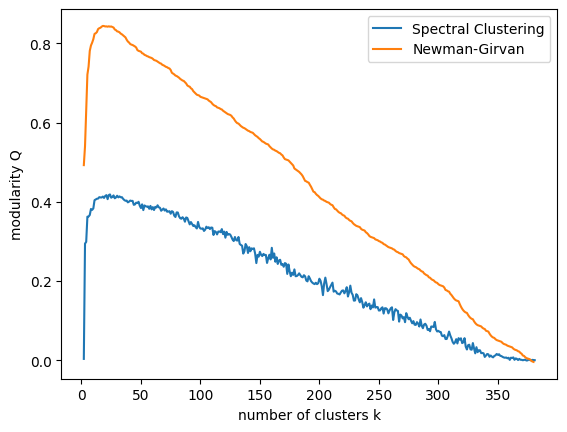

In [7]:
# Collaboration Network https://networkrepository.com/ca-netscience.php
G = nx.read_edgelist('data/ca-netscience-cleaned.mtx')
print('Nodes:',G.number_of_nodes(), 'Edges',  G.number_of_edges())

# compute modularity for both methods
mod_spectral = spectral_clustering_old(G)
mod_new_gir = newman_girvan(G)
X = np.arange(2,G.number_of_nodes()+1)

# plotting
plt.plot(X,mod_spectral,label='Spectral Clustering')
plt.plot(X[:-1],mod_new_gir,label='Newman-Girvan')
plt.xlabel('number of clusters k',)
plt.ylabel('modularity Q')
plt.legend()

Nodes: 183 Edges 2452


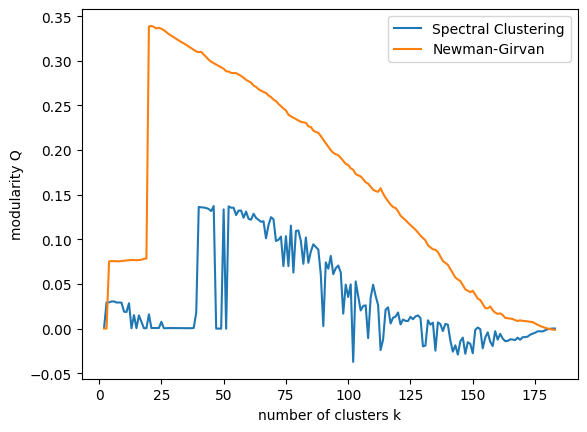

In [6]:
# Miscellaneous Networks https://networkrepository.com/maayan-foodweb.php
G = nx.read_edgelist('data/maayan-foodweb.edges', delimiter=',')
print('Nodes:',G.number_of_nodes(), 'Edges',  G.number_of_edges())


mod_spectral = spectral_clustering_old(G)
mod_new_gir = newman_girvan(G)

X = np.arange(2,G.number_of_nodes()+1)

plt.plot(X,mod_spectral,label='Spectral Clustering')
plt.plot(X,mod_new_gir,label='Newman-Girvan')


plt.xlabel('number of clusters k',)
plt.ylabel('modularity Q')
plt.legend()

Nodes: 643 Edges 2280


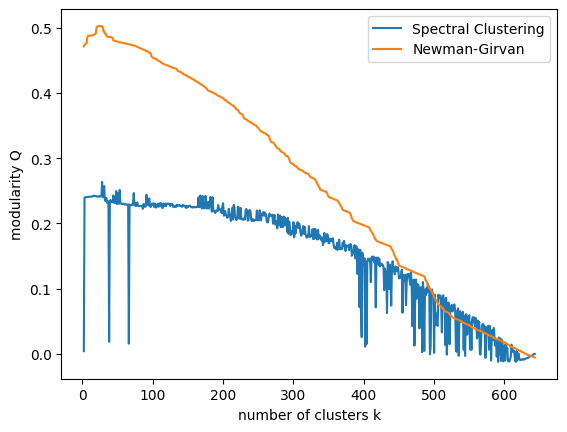

In [23]:
# Web Graph https://networkrepository.com/web-polblogs.php
matrix = mmread("data/web-polblogs.mtx")
G = nx.from_scipy_sparse_array(matrix)
print('Nodes:',G.number_of_nodes(), 'Edges',  G.number_of_edges())

mod_spectral = spectral_clustering_old(G)
mod_new_gir = newman_girvan(G)

X = np.arange(2,G.number_of_nodes()+1)

plt.plot(X,mod_spectral,label='Spectral Clustering')
plt.plot(X,mod_new_gir,label='Newman-Girvan')
plt.xlabel('number of clusters k',)
plt.ylabel('modularity Q')
plt.legend()

Nodes: 143 Edges 623


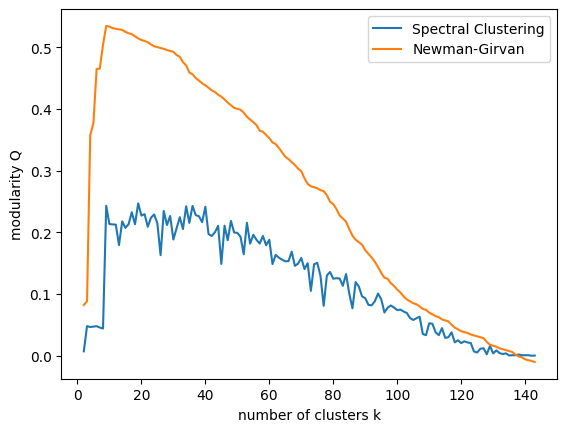

In [24]:
# Email Network https://networkrepository.com/email-enron-only.php
matrix = mmread("data/email-enron-only.mtx")
G = nx.from_scipy_sparse_array(matrix)
#G = nx.read_edgelist('email-enron-only.mtx')
print('Nodes:',G.number_of_nodes(), 'Edges',  G.number_of_edges())

mod_spectral = spectral_clustering_old(G)
mod_new_gir = newman_girvan(G)

X = np.arange(2,G.number_of_nodes()+1)

plt.plot(X,mod_spectral,label='Spectral Clustering')
plt.plot(X,mod_new_gir,label='Newman-Girvan')
plt.xlabel('number of clusters k',)
plt.ylabel('modularity Q')
plt.legend()

Nodes: 516 Edges 1188


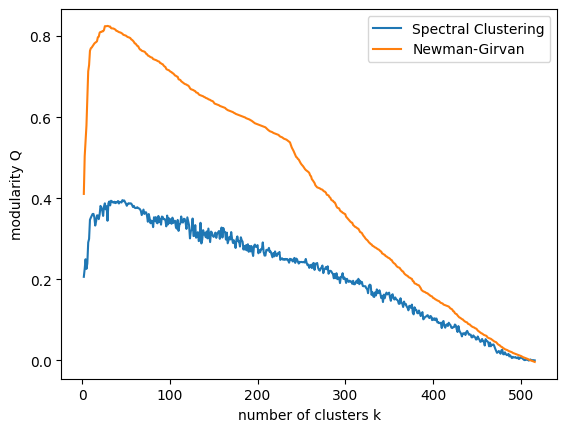

In [25]:
# Biological Network https://networkrepository.com/bio-diseasome.php
matrix = mmread("data/bio-diseasome.mtx")
G = nx.from_scipy_sparse_array(matrix)
#G = nx.read_edgelist('bio-diseasome.mtx')
print('Nodes:',G.number_of_nodes(), 'Edges',  G.number_of_edges())

mod_spectral = spectral_clustering_old(G)
mod_new_gir = newman_girvan(G)

X = np.arange(2,G.number_of_nodes()+1)

plt.plot(X,mod_spectral,label='Spectral Clustering')
plt.plot(X,mod_new_gir,label='Newman-Girvan')
plt.xlabel('number of clusters k',)
plt.ylabel('modularity Q')
plt.legend()

The Newman-Girvan algorithm outperforms the spectral clustering in each of the 5 networks, except for the case of very large amounts of clusters for the Web Graph.

## Part II

In [41]:
from sklearn.covariance import GraphicalLassoCV

num_cortical = 148
X = np.load('data/timeseries_rfMRI_REST1_LR.npz')['timeseries'][0:num_cortical, :]  # we ignore some subcortical areas for this exercise
print(X.shape)
labels = np.load('labels.npz')['labels'][0:num_cortical]
centroids = np.load('centroids.npz')['centroids'][0:num_cortical, :]

(148, 1200)


In [42]:
# instantiate LassoCV model and fit it to brain data (BOLD responses)
model = GraphicalLassoCV()
model.fit(X.T)

# get estimation of precision matrix from model and check shape to be 148x148 not 1200x1200
precision_mat = model.get_precision()
precision_mat.shape

/Users/maxwassermann/code/env/lib/python3.9/site-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


(148, 148)

(1)     $\Large R = - \frac{p_{ij}}{\sqrt{p_{ii}p_{jj}}}$

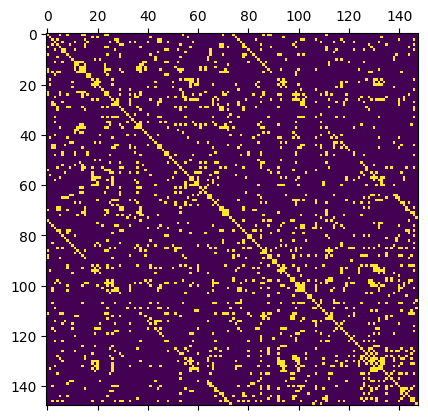

In [43]:
# calculate partial correlation matrix R from precision matrix precision_mat
R = np.zeros_like(precision_mat)
    
# diagonal elements are 1 while the rest is calculated using formula (1)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        if i == j:
            R[i, j] = 1  # Set the diagonal to 1
        else:
            R[i, j] = -precision_mat[i, j] / np.sqrt(precision_mat[i, i] * precision_mat[j, j])

# get adjacency matrix A from partial correlation matrix R and visualize to check plausibility
A = 1.0*(np.abs(R) > 0.0)
plt.matshow(A)

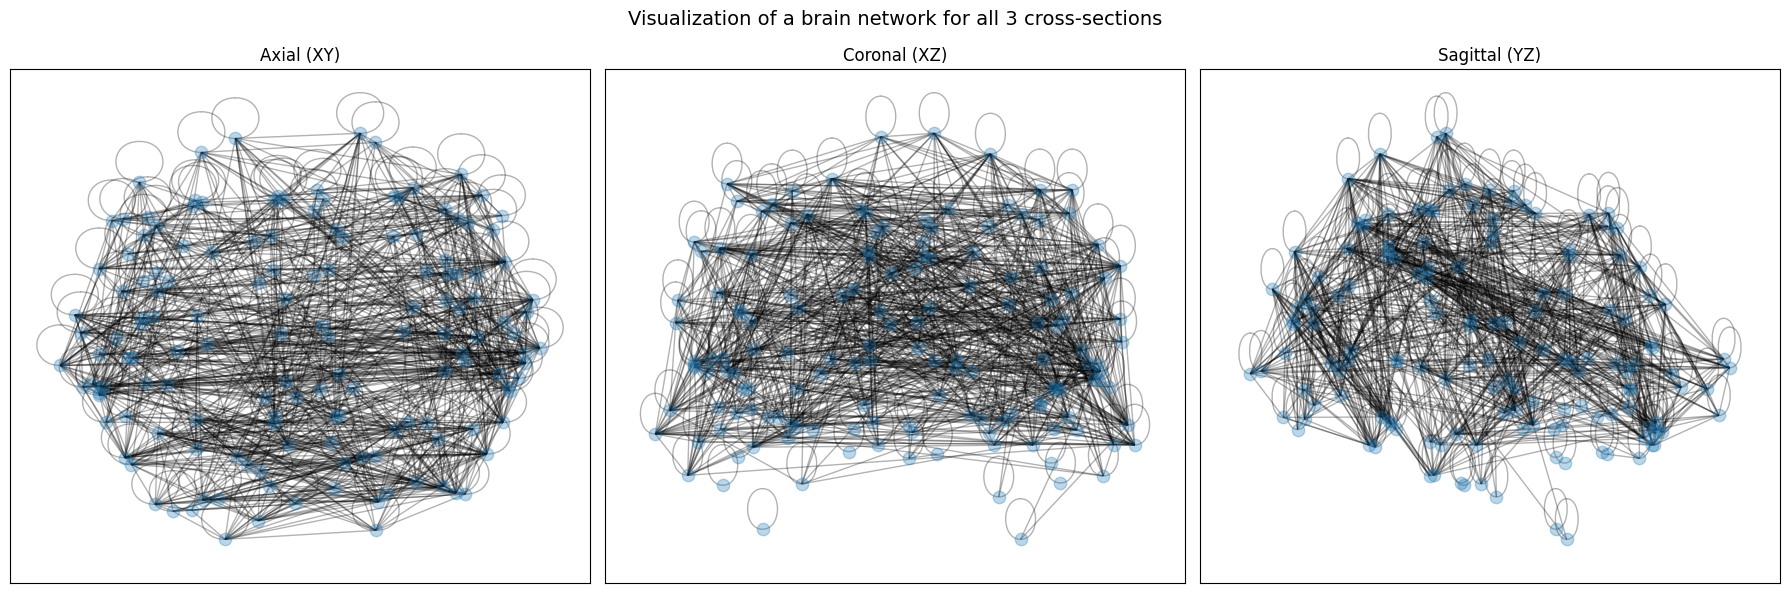

In [44]:
# create network from adjacency matrix
G = nx.from_numpy_array(A)

#create subplots for each plane (3 total)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Visualization of a brain network for all 3 cross-sections', fontsize=14)

# XY plane
axes[0].set_title('Axial (XY)')
nx.draw_networkx(G, pos=centroids[:, :2], ax=axes[0], with_labels=False, node_size=80, alpha=0.3, font_size=8)

# XZ plane 
axes[1].set_title('Coronal (XZ)')
nx.draw_networkx(G, pos=centroids[:, [0, 2]], ax=axes[1], with_labels=False, node_size=80, alpha=0.3, font_size=8)

# YZ plane 
axes[2].set_title('Sagittal (YZ)')
nx.draw_networkx(G, pos=centroids[:, 1:], ax=axes[2], with_labels=False, node_size=80, alpha=0.3, font_size=8)

plt.tight_layout()
plt.show()

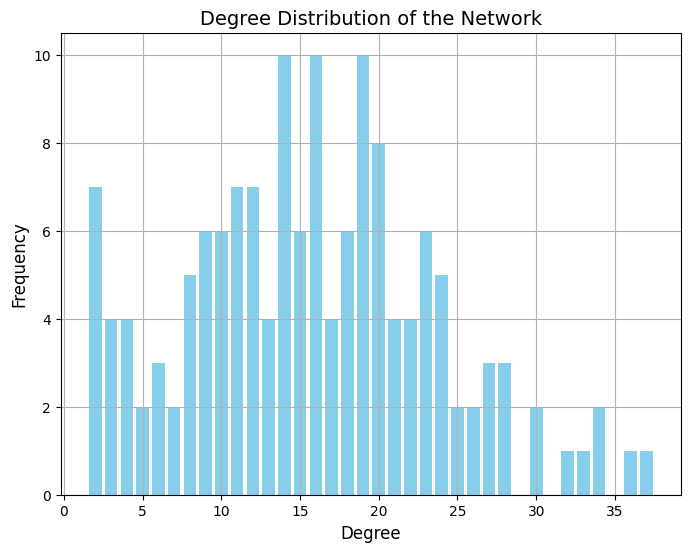

In [45]:
# plot degree distribution
degrees = [d for n, d in G.degree()]
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), align='left', rwidth=0.8, color='skyblue')

plt.title('Degree Distribution of the Network', fontsize=14)
plt.xlabel('Degree', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

We can see a degree distribution that looks symmetrical, meaning most nodes are in the middle with some highly connected and some sparsely connected nodes. This is similar to the degree distributions of the Erdős-Rényi and the Watts-Strogatz Null Models. With the knowledge where the network data came from, the Watts-Strogatz model and its small-worldness characteristic should fit this network best. 

In [46]:
# molloy-reed criterion

# tried doing it by hand to see if it is the same results
mr_crit = np.mean(np.array(degrees)**2) / np.mean(degrees)
print('The networks has a Molloy-Reed Criterion of', mr_crit, 'using the mean of squared degrees.')

from scipy.stats import moment
mr_crit = moment(degrees, 2, center=0)/np.mean(degrees)
print('The networks has a Molloy-Reed Criterion of', mr_crit, 'using the second moment from scipy.stats.')


The networks has a Molloy-Reed Criterion of 19.693562231759653 using the mean of squared degrees.
The networks has a Molloy-Reed Criterion of 19.693562231759653 using the second moment from scipy.stats.


The network has a Molloy-Reed Criterion much larger than 2, which means it has a giant component.

In [47]:
# calculate the critical fraction f_c using formula (2)
fc = 1 - 1 / (mr_crit-1)
print('The networks has a critical fraction f_c of', fc)

The networks has a critical fraction f_c of 0.946505647901552


(2)         $\Large f_C = 1 - \frac{1}{\frac{\langle k^2 \rangle}{\langle k \rangle}-1}$ \
The resulting $f_C ≈ 0.98$ suggests you need to randomly remove 98% of the nodes for the network to completely break down into tiny isolated pieces. This implies the network is increadibly robust to such random attacks. This makes sense as cells die all the time and functionality of the brain remains intact even after head injuries.  

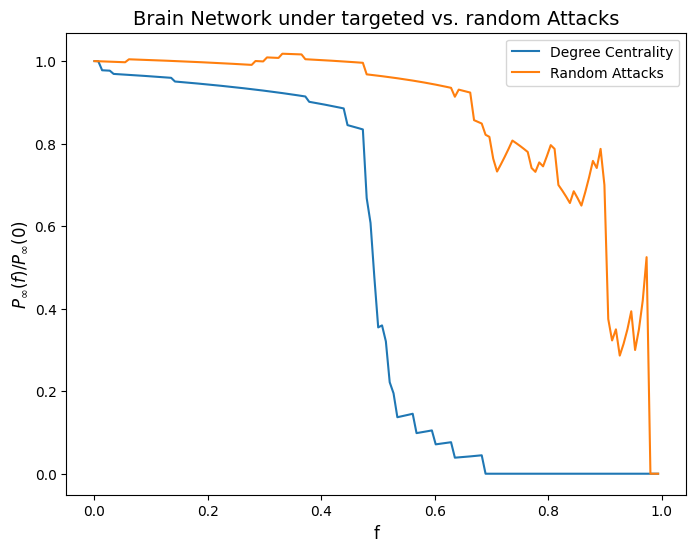

In [48]:
# targeted attacks

# function to calculate P_infinity in each step
def P_infinity(G):

    largest = max(nx.connected_components(G), key=len)

    if len(largest) == 1:
        return 0
    else:
        return len(largest) / len(G)

P_0 = P_infinity(G)
G_attacked = G.copy()
n = G.number_of_nodes()

f = [0]
P_ratio = [1]

for i in range(n-1):
    # get degrees and remove node with highest value
    degree = list(G_attacked.degree())
    top_node = max(degree, key=lambda x: x[1])[0]
    G_attacked.remove_node(top_node)

    # calculate p_infinity and save ratio to P-inf(0)
    P_inf = P_infinity(G_attacked)
    P_ratio.append(P_inf/P_0)
    f.append(1 - (n-1-i) / n)


# same for random attacks
P_ratio_rand = [1]
G_attacked = G.copy()

for i in range(n-1):
    current_nodes = list(G_attacked.nodes)
    random_node = np.random.choice(current_nodes)
    G_attacked.remove_node(random_node)

    P_inf = P_infinity(G_attacked)
    P_ratio_rand.append(P_inf/P_0)



# plotting
plt.figure(figsize=(8, 6))
plt.plot(f,P_ratio, label='Degree Centrality')
plt.plot(f,P_ratio_rand,label='Random Attacks')


plt.title('Brain Network under targeted vs. random Attacks', fontsize=14)
plt.xlabel('f', fontsize=12)
plt.ylabel('$P_\infty(f) / P_\infty(0)$', fontsize=12)
plt.legend()


We can see how much more effective the targeted attack is compared to the random attacks. This plot also validates the calculation of $f_c$ for random attacks from the last excercise.

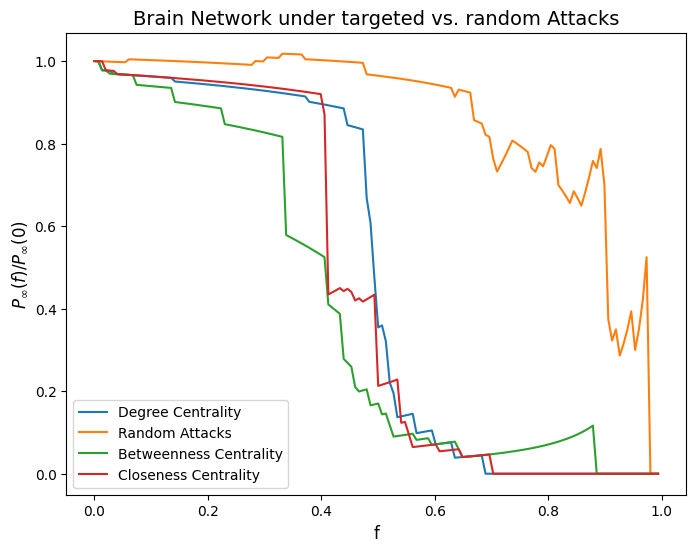

In [49]:
# same for betweenness centrality
P_ratio_between = [1]
G_attacked = G.copy()

for i in range(n-1):
    between = nx.betweenness_centrality(G_attacked)
    top_node = max(between, key=between.get)
    G_attacked.remove_node(top_node)

    P_inf = P_infinity(G_attacked)
    P_ratio_between.append(P_inf/P_0)

# same for eigenvector centrality
P_ratio_close = [1]
G_attacked = G.copy()

for i in range(n-1):
    close = nx.closeness_centrality(G_attacked)
    top_node = max(close, key=close.get)
    G_attacked.remove_node(top_node)

    P_inf = P_infinity(G_attacked)
    P_ratio_close.append(P_inf/P_0)

# plotting
plt.figure(figsize=(8, 6))
plt.plot(f,P_ratio, label='Degree Centrality')
plt.plot(f,P_ratio_rand,label='Random Attacks')
plt.plot(f,P_ratio_between, label='Betweenness Centrality')
plt.plot(f,P_ratio_close,label='Closeness Centrality')


plt.title('Brain Network under targeted vs. random Attacks', fontsize=14)
plt.xlabel('f', fontsize=12)
plt.ylabel('$P_\infty(f) / P_\infty(0)$', fontsize=12)
plt.legend()

From this plot we can see that removing the node with the highest betweenness centrality causes the quickest breakdown of the network, although closeness centrality seems to catch up at around f=0.4 and degree centrality shortly thereafter. For f>0.5 they seem to perform very similarly. Each of these targeted attack methods is much more efficient compared to the random attacks, however.